In [3]:
# 라이브러리
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

from tqdm.notebook import tqdm

In [4]:
# device setting
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(device)

cuda:0


In [5]:
# directory setting
class ROOTDIR:
    train_dir = '/home/kmk/DL_final_project/cityscapes_data/train/'
    val_dir = '/home/kmk/DL_final_project/cityscapes_data/val/'

In [6]:
# image file list
train_filenames = sorted(glob.glob(ROOTDIR.train_dir+"*.jpg"))
val_filenames = sorted(glob.glob(ROOTDIR.val_dir+"*.jpg"))

len(train_filenames), len(val_filenames)

(2975, 500)

In [7]:
# visualize
def show(img_list, train, loop=1):
    if train:
        dir = ROOTDIR.train_dir
    else:
        dir = ROOTDIR.val_dir
        
    for i in range(loop):
        img_dir = os.path.join(dir, img_list[i])
        img = Image.open(img_dir)
        print(f"image path: {dir + img_list[i]}")
        plt.imshow(img)
        plt.title("image")
        plt.show()

image path: /home/kmk/DL_final_project/cityscapes_data/train//home/kmk/DL_final_project/cityscapes_data/train/1.jpg


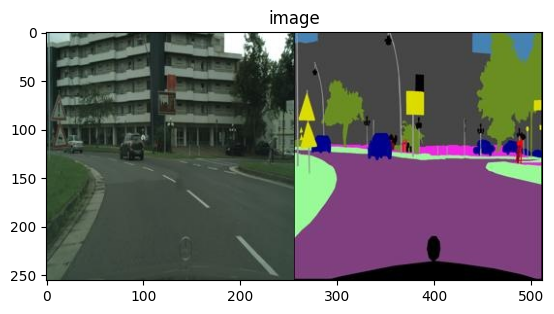

In [8]:
show(img_list=train_filenames, train=True)

In [9]:
# Dataset
class Cityscape(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        
    # img list 길이
    def __len__(self):
        return len(self.img_path)
    
    # get image, label
    def __getitem__(self, idx):
        data = plt.imread(self.img_path[idx])
        
        img, label = data[:, :256, :], data[:, 256:, :]
        
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
            
        return img, label           

In [10]:
# Define Transforms
train_Transforms = transforms.Compose([
    transforms.ToTensor(),
])
val_Transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
# Data Augmentation
train_dataset = Cityscape(train_filenames, train_Transforms)
val_dataset = Cityscape(val_filenames, val_Transforms)

In [12]:
# Batch
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, 1, shuffle=True)

In [13]:
# visualize batch
def show_batch(batch, size):
    img, label = batch[0], batch[1]
    img = img.numpy()
    label = label.numpy()
    
    fig, ax = plt.subplots(size, 2, figsize=(10, 30))
    
    for i in range(size):
        ax[i][0].imshow(np.transpose(img[i], (1, 2, 0)))
        ax[i][1].imshow(np.transpose(label[i], (1, 2, 0)))

/home/kmk/anaconda3/envs/kmk/lib/python3.8/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


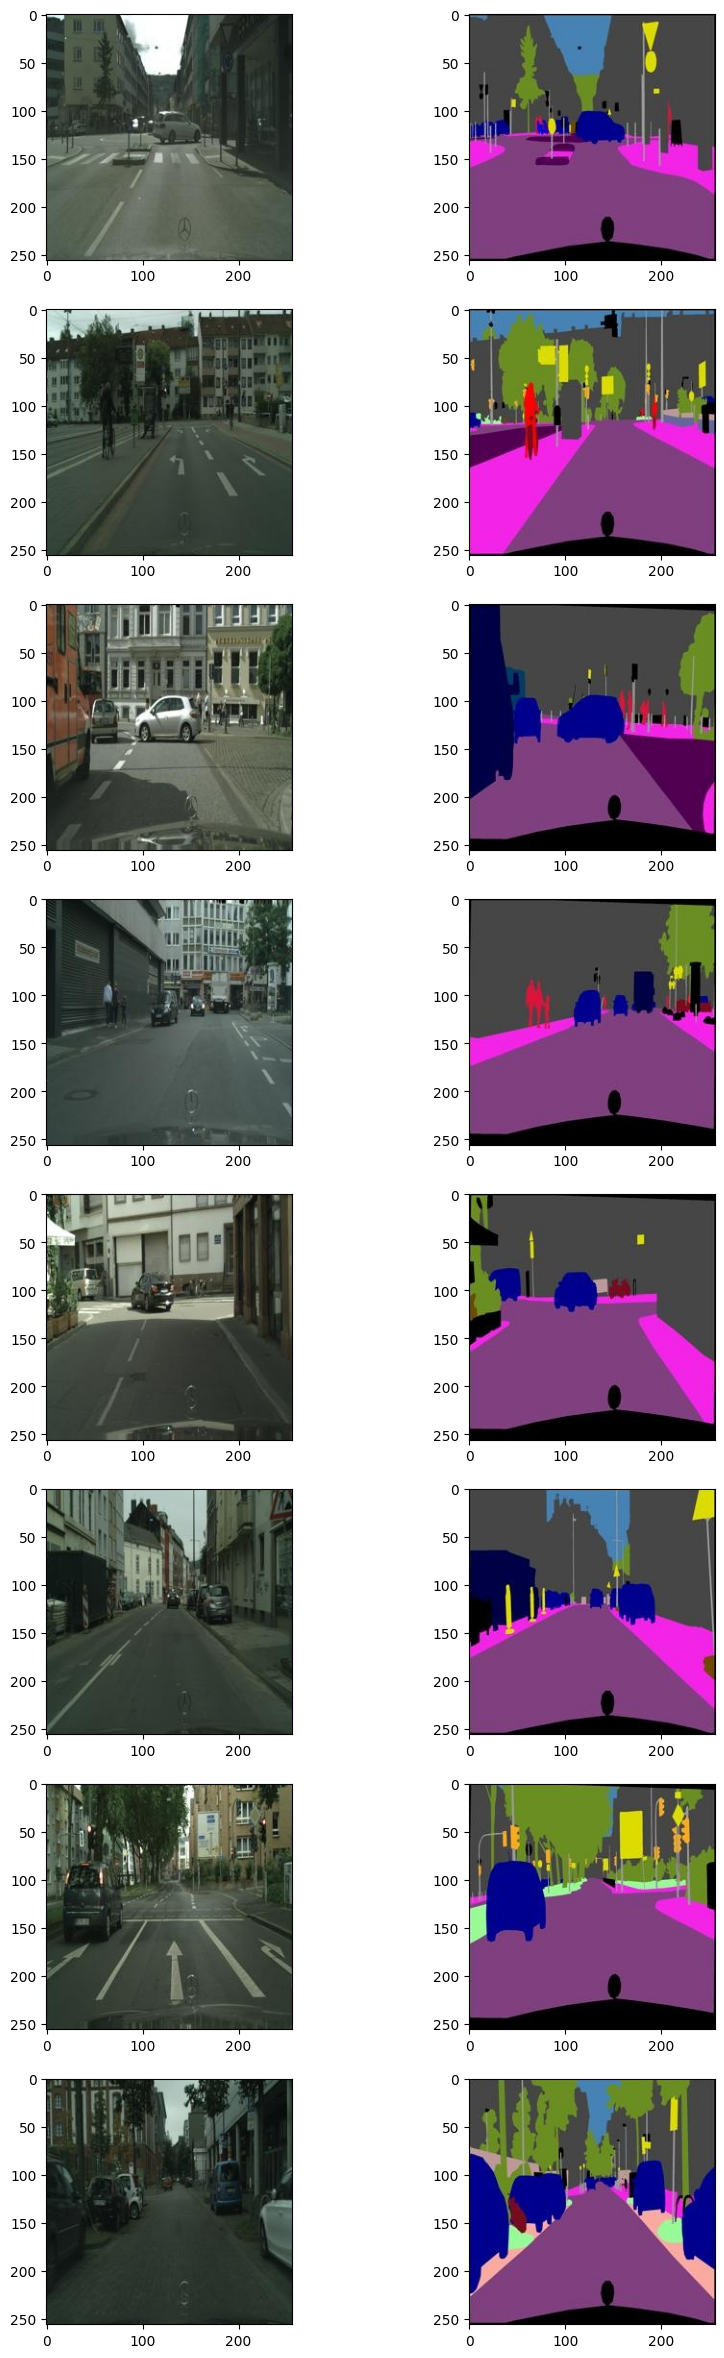

In [14]:
train_iter = iter(train_loader)
val_iter = iter(val_loader)
show_batch(next(train_iter), batch_size)

### Build Model ###

In [15]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        self.num_classes = num_classes
        
        # down convolution
        self.down_conv_1 = self.convBlock(in_channels=3, out_channels=64)
        self.down_conv_2 = self.convBlock(in_channels=64, out_channels=128)
        self.down_conv_3 = self.convBlock(in_channels=128, out_channels=256)
        self.down_conv_4 = self.convBlock(in_channels=256, out_channels=512)
        self.down_conv_5 = self.convBlock(in_channels=512, out_channels=1024)
        
        # Max Pooling
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # up convolution transpose
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
        # up convolution
        self.up_conv_1 = self.convBlock(in_channels=1024, out_channels=512)
        self.up_conv_2 = self.convBlock(in_channels=512, out_channels=256)
        self.up_conv_3 = self.convBlock(in_channels=256, out_channels=128)
        self.up_conv_4 = self.convBlock(in_channels=128, out_channels=64)
        
        # output
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)   
         
    def convBlock(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            )
        return block
    
    def padder(self, tensorL, tensorR):
        if tensorL.shape != tensorR.shape:
            padded = torch.zeros(tensorL.shape)
            padded[:, :, :tensorR.shape[2], :tensorR.shape[3]] = tensorR
            return padded.to(device)
        return tensorR.to(device)
    
    def forward(self, x):
        # encoder
        x1 = self.down_conv_1(x)
        p1 = self.maxPool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.maxPool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.maxPool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.maxPool(x4)
        x5 = self.down_conv_5(p4)
        
        # decoder
        d1 = self.up_conv_trans_1(x5)
        pad1 = self.padder(x4, d1)
        uc1 = self.up_conv_1(torch.cat((x4, pad1), dim=1))
        d2 = self.up_conv_trans_2(uc1)
        pad2 = self.padder(x3, d2)
        uc2 = self.up_conv_2(torch.cat((x3, pad2), dim=1))
        d3 = self.up_conv_trans_3(uc2)
        pad3 = self.padder(x2, d3)
        uc3 = self.up_conv_3(torch.cat((x2, pad3), dim=1))
        d4 = self.up_conv_trans_4(uc3)
        pad4 = self.padder(x1, d4)
        uc4 = self.up_conv_4(torch.cat((x1, pad4), dim=1))
        output = self.output(uc4)
        
        return output

### Train Model ###

In [16]:
# tensorboard
writer = SummaryWriter()

In [17]:
def train_model(model, dataloader, criterion, optimizer, i):
    model.train()
    train_running_loss = 0.0
    
    for j, data in tqdm(dataloader):
        print(j)
        img = data[0].float().to(device)
        mask = data[1].float().to(device)
        
        y_pred = model(img)
        
        optimizer.zero_grad()
        
        loss = criterion(y_pred, mask)
        
        writer.add_scalar("Loss/train", loss, j+i*len(dataloader))
        
        train_running_loss += loss.item()*batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    
    return train_loss

In [18]:
def val_model(model, dataloader, criterion, i):
    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for j, data in enumerate(tqdm(dataloader)):
            img = data[0].float().to(device)
            mask = data[1].float().to(device)
            
            y_pred = model(img)
            
            loss = criterion(y_pred, mask)
            
            writer.add_scalar("Loss/validation", loss, j+i*len(dataloader))
            
            val_running_loss += loss.item()*batch_size
            
        val_loss = val_running_loss / (j+1)
        
    return val_loss, model

In [19]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.val_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model, file_name):
        if self.val_loss is None:
            self.val_loss = val_loss
            self.save_checkpoint(val_loss, model, file_name)
        elif val_loss > self.val_loss + self.delta:
            self.counter += 1
            self.trace_func(f"Early Stopping Counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss = val_loss
            self.save_checkpoint(val_loss, model, file_name)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, file_name):
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), file_name)
        self.val_loss_min = val_loss

In [20]:
epochs = 10
lr = 0.01
num_classes = 30

In [21]:
model = UNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
es = EarlyStopping(patience=20, verbose=False, delta=0.01)
train_loss_arr = []
val_loss_arr = []

In [22]:
""" error 수정하기"""

for i in tqdm(range(epochs)):
    train_loss = train_model(model=model, dataloader=train_loader, criterion=criterion, optimizer=optimizer, i=i)
    val_loss, model = val_model(model=model, dataloader=val_loader, criterion=criterion, i=i)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    
    TRAINED_FILE = f"/home/kmk/DL_final_project/checkpoint/unet_scratch_{i}_epoch.pth"
    
    es(val_loss, model, TRAINED_FILE)
    
    if es.early_stop:
        writer.close()
        break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

tensor([[[[0.4392, 0.6314, 0.6588,  ..., 0.2549, 0.4039, 0.4784],
          [0.3569, 0.6196, 0.7098,  ..., 0.2863, 0.4196, 0.4863],
          [0.2745, 0.5529, 0.6706,  ..., 0.3412, 0.4471, 0.5020],
          ...,
          [0.3333, 0.3529, 0.3451,  ..., 0.2667, 0.2941, 0.3216],
          [0.3333, 0.3529, 0.3451,  ..., 0.2353, 0.2706, 0.2980],
          [0.3333, 0.3529, 0.3451,  ..., 0.2431, 0.2941, 0.3255]],

         [[0.5333, 0.7216, 0.7451,  ..., 0.4000, 0.5490, 0.5765],
          [0.4510, 0.7098, 0.7961,  ..., 0.4314, 0.5569, 0.5843],
          [0.3686, 0.6431, 0.7569,  ..., 0.4784, 0.5765, 0.6000],
          ...,
          [0.3882, 0.4078, 0.4000,  ..., 0.3059, 0.3333, 0.3490],
          [0.3882, 0.4078, 0.4000,  ..., 0.2745, 0.3098, 0.3255],
          [0.3882, 0.4078, 0.4000,  ..., 0.2824, 0.3333, 0.3529]],

         [[0.4471, 0.6431, 0.6941,  ..., 0.3725, 0.5216, 0.5529],
          [0.3647, 0.6314, 0.7451,  ..., 0.4039, 0.5333, 0.5608],
          [0.2824, 0.5647, 0.7059,  ..., 0

ValueError: expected 4D input (got 3D input)